# Prophet Forecasting

Prophet is an open source model created by Meta Open Source. This notebook will analyse the utilisation of Prophet for spend forecasting for AI-Based Financial Assistant.

In [37]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

## User Configurables

User configurables will be variables automatically inputted and taken from the users settings.

In [38]:
ANNUAL_SALARY = 24680           # user-provided average UK salary (annual post tax, NI, pension)
MONTHLY_INCOME = ANNUAL_SALARY / 12.0

SAVINGS_GOAL = 250              # £ per month target savings
GROCERY_WEEKLY_CAP = 35         # £ per week for groceries
GROCERY_MONTHLY_CAP = GROCERY_WEEKLY_CAP * 4  # approximate monthly cap (~£140)

HIST_MONTHS = 24                # months of historical data to simulate
FORECAST_MONTHS = 12            # months to forecast ahead
ANNUAL_INFLATION = 0.04         # default 4% annual inflation (adjustable)


In [39]:
np.random.seed(42)              # reproducible results

base_monthly = {
    'Housing': 1410,            # rent — tune this to your local typical rent
    'Utilities': 250.0,         # combined electric + water + internet + phone + council tax
    'Food_Groceries': 140.0,    # groceries (we will cap this to the weekly allowance)
    'Food_EatingOut': 100.0,    # casual eating out / takeaways
    'Transport': 180.0          # transport (public transport / fuel / etc)
}

## Building Simulated Historical Dataset

The historical dataset is important for Prophet forecasting so we can analyse previous costs to forecast upcoming ones.

In [40]:
dates = pd.date_range(start='2025-01-01', periods=HIST_MONTHS, freq='ME')
records = []

for i, d in enumerate(dates):
    # monthly inflation factor (compounded every month)
    month_inflation = (1 + ANNUAL_INFLATION / 12) ** i

    # For each category, apply inflation and small random noise
    for cat, base in base_monthly.items():
        noise = np.random.normal(loc=1.0, scale=0.03)  # small gaussian noise ±3%
        amount = base * month_inflation * noise

        # If groceries, ensure historical values do not violate the weekly cap too badly
        if cat == 'Food_Groceries':
            amount = min(amount, GROCERY_MONTHLY_CAP * np.random.uniform(0.95, 1.05))
            # this allows historical to sometimes be slightly below cap — realistic
        records.append({'date': d, 'category': cat, 'amount': round(amount, 2)})

df_hist = pd.DataFrame(records)

## Category Forecasting

We will forecast each category individually using Prophet

In [41]:
forecasts = []

for cat in df_hist['category'].unique():
    # Prepare data for Prophet: columns 'ds' and 'y'
    cat_df = df_hist[df_hist['category'] == cat][['date', 'amount']].rename(columns={'date': 'ds', 'amount': 'y'})

    # Initialize Prophet model
    # By default it will attempt to detect trends. Turn off weekly/day seasonality as monthly data suffices.
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    m.fit(cat_df)

    # Create future dataframe (monthly frequency)
    future = m.make_future_dataframe(periods=FORECAST_MONTHS, freq='ME')
    forecast = m.predict(future)

    # Keep only needed columns and add category label
    keep_cols = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
    forecast_small = forecast[keep_cols].copy()
    forecast_small['category'] = cat

    # If category is Food_Groceries, enforce the monthly cap on the forecasted yhat
    if cat == 'Food_Groceries':
        forecast_small['yhat_capped'] = forecast_small['yhat'].apply(lambda x: min(x, GROCERY_MONTHLY_CAP))
        # also cap lower/upper for more conservative intervals (optional)
        forecast_small['yhat_lower_capped'] = forecast_small['yhat_lower'].apply(lambda x: min(x, GROCERY_MONTHLY_CAP))
        forecast_small['yhat_upper_capped'] = forecast_small['yhat_upper'].apply(lambda x: min(x, GROCERY_MONTHLY_CAP))
    else:
        # for non-grocery categories, capped values are same as original
        forecast_small['yhat_capped'] = forecast_small['yhat']
        forecast_small['yhat_lower_capped'] = forecast_small['yhat_lower']
        forecast_small['yhat_upper_capped'] = forecast_small['yhat_upper']

    # Append
    forecasts.append(forecast_small)

# Combine category forecasts into a single DataFrame
forecast_all = pd.concat(forecasts)

22:27:50 - cmdstanpy - INFO - Chain [1] start processing
22:27:57 - cmdstanpy - INFO - Chain [1] done processing
/Users/aren/code/university/personal-finance-ai/.venv/lib/python3.14/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
22:27:57 - cmdstanpy - INFO - Chain [1] start processing
22:28:04 - cmdstanpy - INFO - Chain [1] done processing
/Users/aren/code/university/personal-finance-ai/.venv/lib/python3.14/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
22:28:04 - cmdstanpy - INFO - Chain [1] start processing
22:28:11 - cmdstanpy - INFO - Chain [1] done processing
/Users/aren/code/university/personal-finance-ai/.venv/lib/python3.14/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please

## Build a monthly summary with actuals and forecasts


In [42]:
# 1) Historical totals (per-month)
hist_totals = df_hist.groupby('date')['amount'].sum().reset_index().rename(columns={'date': 'month', 'amount': 'total_spend_actual'})

# 2) Forecast totals: for each ds (month) sum yhat_capped across categories
forecast_totals = (
    forecast_all.groupby('ds')['yhat_capped'].sum().reset_index().rename(columns={'ds': 'month', 'yhat_capped': 'total_spend_forecast'})
)

# 3) Merge historical and forecast totals
combined = pd.merge(hist_totals, forecast_totals, on='month', how='outer').sort_values('month').reset_index(drop=True)

# 4) Fill NaNs sensibly: historical months will have no forecast? Actually forecast includes all months including history.
#    To ensure consistent values, prefer historical actuals for historical months and forecast for future months.
combined['total_spend'] = combined.apply(
    lambda row: row['total_spend_actual'] if not np.isnan(row['total_spend_actual']) else row['total_spend_forecast'],
    axis=1
)

# 5) Compute savings = income - total_spend
combined['monthly_income'] = MONTHLY_INCOME
combined['savings'] = combined['monthly_income'] - combined['total_spend']
combined['savings_goal_met'] = combined['savings'] >= SAVINGS_GOAL

# Keep only the next FORECAST_MONTHS rows that are forecasting or mix of last history + future:
# We'll show the last HIST_MONTHS (history) and then the next FORECAST_MONTHS (future)
# For the user's quick check, show the next FORECAST_MONTHS months from the last historical month
last_hist_month = df_hist['date'].max()
show_start = last_hist_month + pd.offsets.MonthBegin(1)  # month after last history
show_end = show_start + pd.offsets.MonthEnd(FORECAST_MONTHS - 1)

# Prepare a month-level table for the forecast period
forecast_period_mask = (combined['month'] >= show_start) & (combined['month'] <= show_end)
forecast_period_table = combined.loc[forecast_period_mask, ['month', 'total_spend', 'monthly_income', 'savings', 'savings_goal_met']].copy()
forecast_period_table['month'] = forecast_period_table['month'].dt.to_period('M').dt.to_timestamp()

# Round values for readability
forecast_period_table[['total_spend', 'monthly_income', 'savings']] = forecast_period_table[['total_spend', 'monthly_income', 'savings']].round(2)


## Breakdown by category

In [43]:
# Pivot forecast_all for the forecast months to show predicted per-category amounts (capped where applicable)
# Keep only rows in the forecast window
forecast_window = forecast_all[(forecast_all['ds'] >= show_start) & (forecast_all['ds'] <= show_end)].copy()

# Select columns and use capped yhat values
forecast_window['yhat_final'] = forecast_window['yhat_capped']
pivot = forecast_window.pivot_table(index='ds', columns='category', values='yhat_final', aggfunc='first').reset_index().rename(columns={'ds': 'month'})

# Round pivot values
for c in pivot.columns:
    if c != 'month':
        pivot[c] = pivot[c].round(2)

# Merge pivot into the forecast_period_table for a friendly combined view
display_table = pd.merge(forecast_period_table, pivot, left_on='month', right_on='month', how='left')


## Output



Monthly income assumed: £2056.67
Savings goal: £250 / month
Grocery weekly cap: £35  (≈ £140 / month)

Forecast summary (next 12 months):


,month,total_spend,monthly_income,savings,savings_goal_met,Food_EatingOut,Food_Groceries,Housing,Transport,Utilities
0,2027-01-01,2117.46,2056.67,-60.79,False,NaN,NaN,NaN,NaN,NaN
1,2027-02-01,2034.35,2056.67,22.32,False,NaN,NaN,NaN,NaN,NaN
2,2027-03-01,2292.17,2056.67,-235.51,False,NaN,NaN,NaN,NaN,NaN
3,2027-04-01,2299.15,2056.67,-242.48,False,NaN,NaN,NaN,NaN,NaN
4,2027-05-01,2059.54,2056.67,-2.87,False,NaN,NaN,NaN,NaN,NaN
5,2027-06-01,2171.90,2056.67,-115.23,False,NaN,NaN,NaN,NaN,NaN
6,2027-07-01,2340.80,2056.67,-284.14,False,NaN,NaN,NaN,NaN,NaN
7,2027-08-01,2005.15,2056.67,51.52,False,NaN,NaN,NaN,NaN,NaN
8,2027-09-01,2202.20,2056.67,-145.53,False,NaN,NaN,NaN,NaN,NaN
9,2027-10-01,2073.55,2056.67,-16.88,False,NaN,NaN,NaN,NaN,NaN


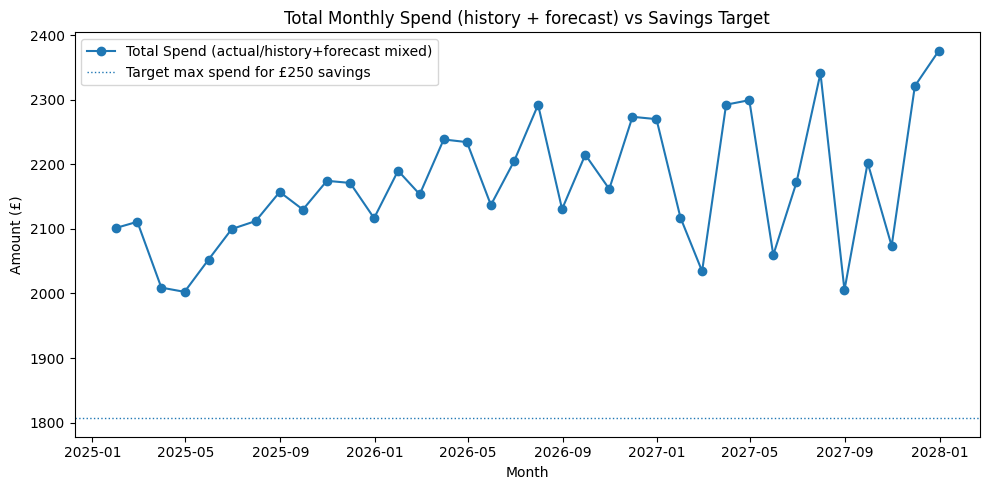

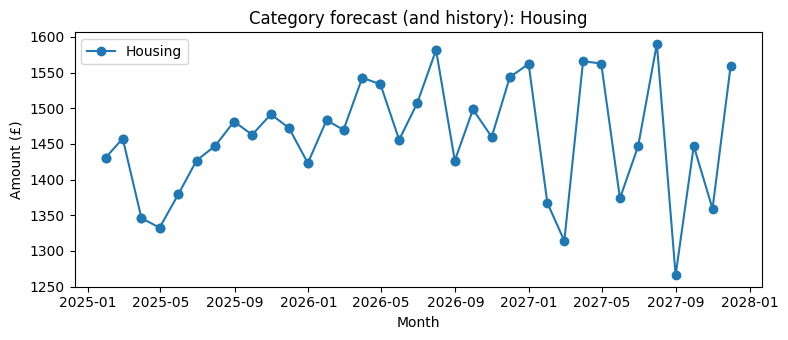

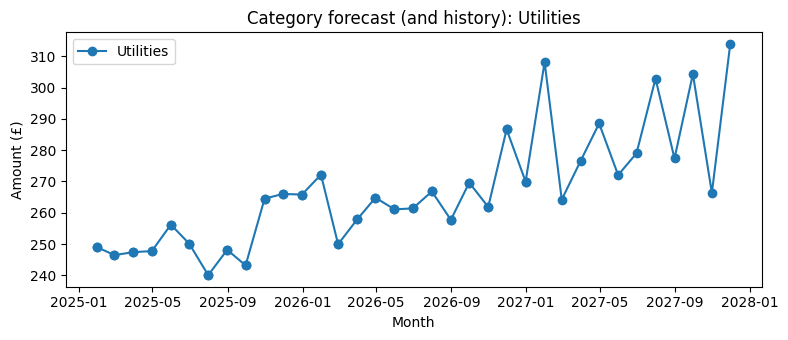

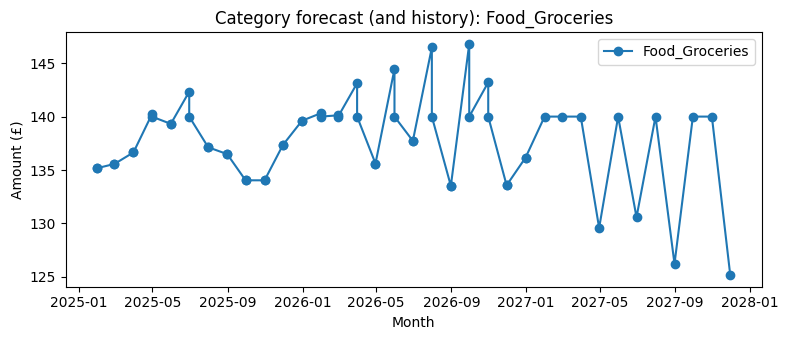

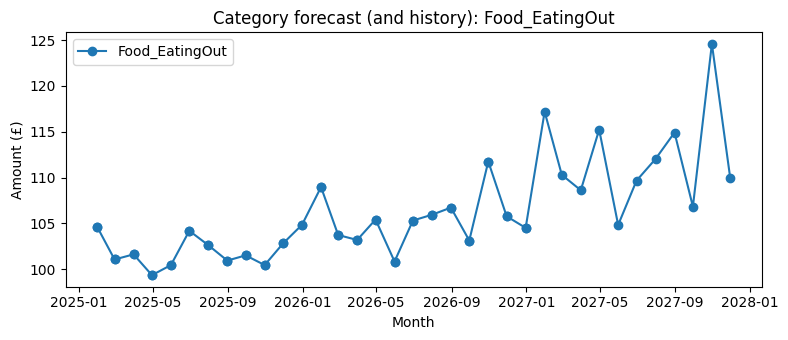

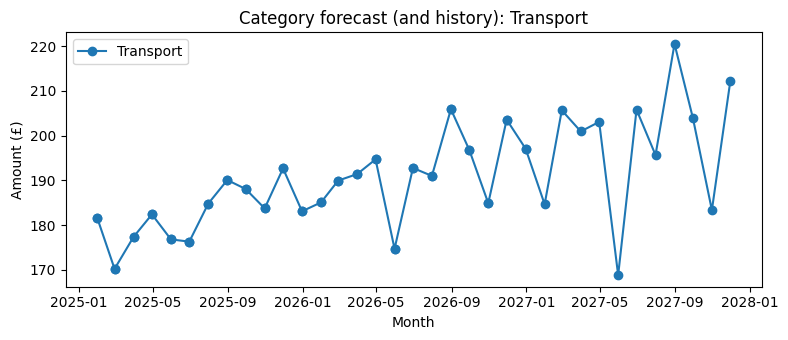


Savings goal check (forecast months):
  month  savings  savings_goal_met
2027-01   -60.79             False
2027-02    22.32             False
2027-03  -235.51             False
2027-04  -242.48             False
2027-05    -2.87             False
2027-06  -115.23             False
2027-07  -284.14             False
2027-08    51.52             False
2027-09  -145.53             False
2027-10   -16.88             False
2027-11  -264.30             False


In [44]:
print(f"Monthly income assumed: £{MONTHLY_INCOME:.2f}")
print(f"Savings goal: £{SAVINGS_GOAL} / month")
print(f"Grocery weekly cap: £{GROCERY_WEEKLY_CAP}  (≈ £{GROCERY_MONTHLY_CAP} / month)\n")

# Show the tabular forecast for the next {FORECAST_MONTHS} months
print("Forecast summary (next {} months):".format(FORECAST_MONTHS))
display(display_table)   # In Jupyter this will render a neat table

# 1) Plot total spend (history + forecast) vs target spend (income - savings goal)
plt.figure(figsize=(10, 5))
# Prepare timeline for plotting: use combined table months
plt.plot(combined['month'], combined['total_spend'], marker='o', label='Total Spend (actual/history+forecast mixed)')
# horizontal line showing max spend allowed to meet savings goal = income - savings_goal
target_spend = MONTHLY_INCOME - SAVINGS_GOAL
plt.axhline(y=target_spend, linestyle=':', label=f'Target max spend for £{SAVINGS_GOAL} savings', linewidth=1)
plt.title('Total Monthly Spend (history + forecast) vs Savings Target')
plt.xlabel('Month')
plt.ylabel('Amount (£)')
plt.legend()
plt.tight_layout()
plt.show()

# 2) Optional: per-category forecast chart (stacked-style visual would be nicer but keep simple line plots)
for cat in df_hist['category'].unique():
    # get category forecast series (capped) for the plotting window (history + forecast)
    # build a series that contains both historical and forecasted values for continuity
    hist_cat = df_hist[df_hist['category'] == cat][['date', 'amount']].rename(columns={'date': 'month', 'amount': 'value'})
    fut_cat = forecast_all[forecast_all['category'] == cat][['ds', 'yhat_capped']].rename(columns={'ds': 'month', 'yhat_capped': 'value'})
    combined_cat = pd.merge(
        pd.DataFrame({'month': pd.date_range(df_hist['date'].min(), show_end, freq='ME')}),
        pd.concat([hist_cat, fut_cat.rename(columns={'value': 'value'})], ignore_index=True),
        on='month',
        how='left'
    )
    # fill forward/backfill small gaps if any
    combined_cat['value'] = combined_cat['value'].interpolate().ffill().bfill()

    plt.figure(figsize=(8, 3.5))
    plt.plot(combined_cat['month'], combined_cat['value'], marker='o', label=f'{cat}')
    plt.title(f'Category forecast (and history): {cat}')
    plt.xlabel('Month')
    plt.ylabel('Amount (£)')
    plt.legend()
    plt.tight_layout()
    plt.show()

df_hist

# Final textual check: show whether savings goal is met for each forecast month
goal_check = display_table[['month', 'savings', 'savings_goal_met']].copy()
goal_check['month'] = goal_check['month'].dt.to_period('M').astype(str)
print("\nSavings goal check (forecast months):")
print(goal_check.to_string(index=False))